In [1]:
%matplotlib inline
import numpy as np
import openmc
import matplotlib.pyplot as plt # importing matlpotlib for creating figures with the dependencies
import warnings
import os
warnings.simplefilter('ignore')

In [2]:
def clean_previous_output():
    for file in os.listdir("."):
        if file.endswith(".h5"):
            print("File {} was removed".format(os.path.abspath(file)))
            os.remove(os.path.abspath(file))

Creating materials

In [3]:
# Functions for defining materials
def make_materials(enr=4.0, fuel_temperature=300.0, cladding_temperature=300.0, moderator_temperature=300.0, 
                   fuel_density=10.0, cladding_density=6.6, moderator_density=1.0):
    # Defining uranium dioxide
    uo2 = openmc.Material(name="uo2")
    uo2.add_element('U', 1.0, enrichment=enr)
    uo2.add_element('O', 2.0)
    uo2.set_density('g/cm3', fuel_density)
    uo2.temperature = fuel_temperature

    # Zirconium
    zirconium = openmc.Material(name="zirconium")
    zirconium.add_element('Zr', 1.0)
    zirconium.set_density('g/cm3', cladding_density)
    zirconium.temperature = cladding_temperature

    # Water
    water = openmc.Material(name="h2o")
    water.add_element('H', 2.0)
    water.add_element('O', 1.0)
    water.set_density('g/cm3', moderator_density)
    water.add_s_alpha_beta('c_H_in_H2O')
    water.temperature = moderator_temperature

    materials = openmc.Materials([uo2, zirconium, water])
    materials.export_to_xml()
    return materials

Creating geometry

In [4]:
# Functions for geometry
def make_geometry(materials, fuel_rad=0.39, clad_inner_rad=0.40, clad_outer_rad=0.46, pitch=1.26):
    fuel_outer_radius = openmc.ZCylinder(r=fuel_rad)
    clad_inner_radius = openmc.ZCylinder(r=clad_inner_rad)
    clad_outer_radius = openmc.ZCylinder(r=clad_outer_rad)

    fuel_region = -fuel_outer_radius
    gap_region = +fuel_outer_radius & -clad_inner_radius
    clad_region = +clad_inner_radius & -clad_outer_radius

    fuel = openmc.Cell(name='fuel')
    fuel.fill = materials[0]
    fuel.region = fuel_region

    gap = openmc.Cell(name='air gap')
    gap.region = gap_region

    clad = openmc.Cell(name='clad')
    clad.fill = materials[1]
    clad.region = clad_region

#     pitch = 1.26
    left = openmc.XPlane(-pitch/2, boundary_type='reflective')
    right = openmc.XPlane(pitch/2, boundary_type='reflective')
    bottom = openmc.YPlane(-pitch/2, boundary_type='reflective')
    top = openmc.YPlane(pitch/2, boundary_type='reflective')

    water_region = +left & -right & +bottom & -top & +clad_outer_radius

    moderator = openmc.Cell(name='moderator')
    moderator.fill = materials[2]
    moderator.region = water_region

    root_universe = openmc.Universe(cells=(fuel, gap, clad, moderator))
    geometry = openmc.Geometry(root_universe)
    geometry.export_to_xml()

Creating initial source and settings

In [5]:
# Function for defining settings
def make_settings(batches=150, inactive=50, particles=500):
    # Create a point source
    point = openmc.stats.Point((0, 0, 0))
    source = openmc.Source(space=point)

    settings = openmc.Settings()
    settings.source = source
    settings.batches = batches
    settings.inactive = inactive
    settings.particles = particles
    settings.temperature = {'method':'interpolation'}
    settings.export_to_xml()

We can start analysis of the model's parameters on effective multiplication factor (keff)

Define number of praticles per batch and number of threads

In [6]:
nthreads = 24
nparticles = 1000

# Keff vs Fuel Enrichment

In [7]:
clean_previous_output()
enrichment = np.arange(1, 91, 1)
batches = 150
keffs = []
std_devs = []
for enr in enrichment:
    print("Enrichment = {:.2f}%".format(enr))
    mats = make_materials(enr=enr)
    make_geometry(materials=mats)
    make_settings(batches=batches, particles=nparticles)
    openmc.run(threads=nthreads, output=False)
    sp = openmc.StatePoint('statepoint.' + str(batches) + '.h5')
    keffs.append(sp.keff.nominal_value)
    std_devs.append(sp.keff.std_dev)
    print("    Keff = {:.5f} +/- {:.5f}".format(sp.keff.nominal_value, sp.keff.std_dev))
    sp.close()

File /mnt/c/Users/dzianisuser/Projects/engg341/openmc/statepoint.150.h5 was removed
File /mnt/c/Users/dzianisuser/Projects/engg341/openmc/summary.h5 was removed
Enrichment = 1.00%
    Keff = 1.03954 +/- 0.00263
Enrichment = 2.00%
    Keff = 1.28132 +/- 0.00296
Enrichment = 3.00%
    Keff = 1.39773 +/- 0.00278
Enrichment = 4.00%
    Keff = 1.46568 +/- 0.00277
Enrichment = 5.00%
    Keff = 1.50160 +/- 0.00270
Enrichment = 6.00%
    Keff = 1.52808 +/- 0.00301
Enrichment = 7.00%
    Keff = 1.54686 +/- 0.00256
Enrichment = 8.00%
    Keff = 1.56502 +/- 0.00260
Enrichment = 9.00%
    Keff = 1.57993 +/- 0.00266
Enrichment = 10.00%
    Keff = 1.59038 +/- 0.00267
Enrichment = 11.00%
    Keff = 1.59799 +/- 0.00264
Enrichment = 12.00%
    Keff = 1.59747 +/- 0.00226
Enrichment = 13.00%
    Keff = 1.61241 +/- 0.00253
Enrichment = 14.00%
    Keff = 1.61269 +/- 0.00272
Enrichment = 15.00%
    Keff = 1.62301 +/- 0.00283
Enrichment = 16.00%
    Keff = 1.62359 +/- 0.00247
Enrichment = 17.00%
    Keff = 1

Plotting the results with errorbars

<ErrorbarContainer object of 3 artists>

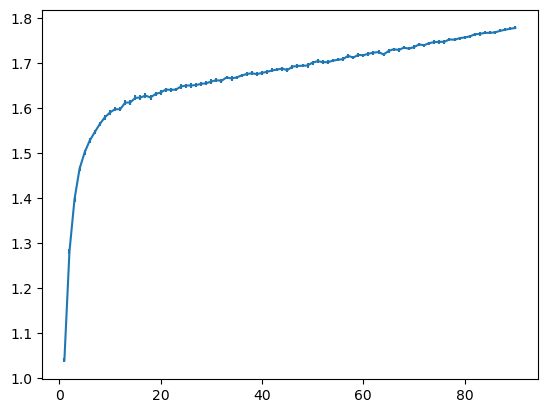

In [8]:
keffs = np.array(keffs)
std_devs = np.array(std_devs)
plt.errorbar(enrichment, keffs, yerr=2*std_devs)

# Keff vs Pitch

In [9]:
clean_previous_output()
pitches = np.arange(1.0, 1.21, 0.01)
keffs = []
std_devs = []
batches = 150
for pitch in pitches:
    print("Pitch = {:.2f} cm".format(pitch))
    mats = make_materials()
    make_geometry(materials=mats, pitch=pitch)
    make_settings(batches=batches, particles=nparticles)
    openmc.run(threads=nthreads, output=False)
    sp = openmc.StatePoint('statepoint.' + str(batches) + '.h5')
    keffs.append(sp.keff.nominal_value)
    std_devs.append(sp.keff.std_dev)
    print("    Keff = {:.5f} +/- {:.5f}".format(sp.keff.nominal_value, sp.keff.std_dev))
    sp.close()

File /mnt/c/Users/dzianisuser/Projects/engg341/openmc/statepoint.150.h5 was removed
File /mnt/c/Users/dzianisuser/Projects/engg341/openmc/summary.h5 was removed
Pitch = 1.00 cm
    Keff = 1.28138 +/- 0.00306
Pitch = 1.01 cm
    Keff = 1.29406 +/- 0.00288
Pitch = 1.02 cm
    Keff = 1.30565 +/- 0.00316
Pitch = 1.03 cm
    Keff = 1.31867 +/- 0.00285
Pitch = 1.04 cm
    Keff = 1.33226 +/- 0.00286
Pitch = 1.05 cm
    Keff = 1.34673 +/- 0.00311
Pitch = 1.06 cm
    Keff = 1.34800 +/- 0.00318
Pitch = 1.07 cm
    Keff = 1.36070 +/- 0.00264
Pitch = 1.08 cm
    Keff = 1.36927 +/- 0.00312
Pitch = 1.09 cm
    Keff = 1.37962 +/- 0.00296
Pitch = 1.10 cm
    Keff = 1.38477 +/- 0.00281
Pitch = 1.11 cm
    Keff = 1.39345 +/- 0.00278
Pitch = 1.12 cm
    Keff = 1.39623 +/- 0.00313
Pitch = 1.13 cm
    Keff = 1.40500 +/- 0.00297
Pitch = 1.14 cm
    Keff = 1.41359 +/- 0.00273
Pitch = 1.15 cm
    Keff = 1.41936 +/- 0.00274
Pitch = 1.16 cm
    Keff = 1.42085 +/- 0.00268
Pitch = 1.17 cm
    Keff = 1.43503 +/- 0

Plotting the results

<ErrorbarContainer object of 3 artists>

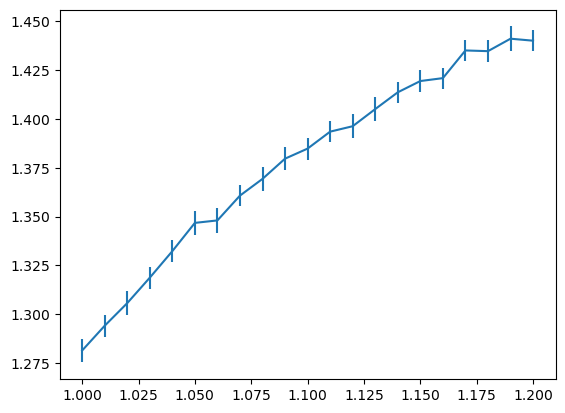

In [10]:
keffs = np.array(keffs)
std_devs = np.array(std_devs)
plt.errorbar(pitches, keffs, yerr=2*std_devs)

# Keff vs Fuel Temperature

In [11]:
clean_previous_output()
temperatures = np.arange(300, 1200, 100)
keffs = []
std_devs = []
batches = 150
for temp in temperatures:
    print("Temperature = {:.1f} K".format(temp))
    mats = make_materials(fuel_temperature=temp)
    make_geometry(materials=mats)
    make_settings(batches=batches, particles=nparticles)
    openmc.run(threads=nthreads, output=False)
    sp = openmc.StatePoint('statepoint.' + str(batches) + '.h5')
    keffs.append(sp.keff.nominal_value)
    std_devs.append(sp.keff.std_dev)
    print("    Keff = {:.5f} +/- {:.5f}".format(sp.keff.nominal_value, sp.keff.std_dev))
    sp.close()

File /mnt/c/Users/dzianisuser/Projects/engg341/openmc/statepoint.150.h5 was removed
File /mnt/c/Users/dzianisuser/Projects/engg341/openmc/summary.h5 was removed
Temperature = 300.0 K
    Keff = 1.46568 +/- 0.00277
Temperature = 400.0 K
    Keff = 1.45809 +/- 0.00302
Temperature = 500.0 K
    Keff = 1.45354 +/- 0.00280
Temperature = 600.0 K
    Keff = 1.45015 +/- 0.00296
Temperature = 700.0 K
    Keff = 1.44126 +/- 0.00287
Temperature = 800.0 K
    Keff = 1.44358 +/- 0.00265
Temperature = 900.0 K
    Keff = 1.44238 +/- 0.00270
Temperature = 1000.0 K
    Keff = 1.43980 +/- 0.00290
Temperature = 1100.0 K
    Keff = 1.43853 +/- 0.00255


Plotting the results

<ErrorbarContainer object of 3 artists>

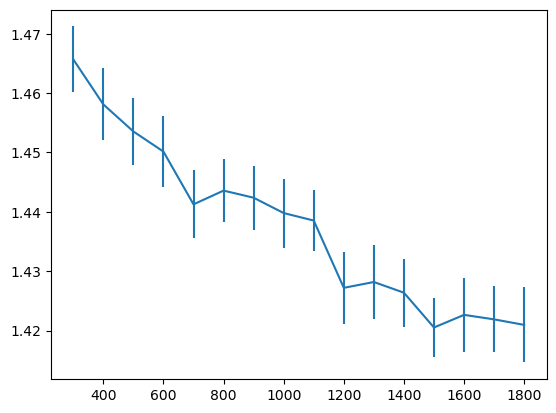

In [22]:
keffs = np.array(keffs)
std_devs = np.array(std_devs)
plt.errorbar(temperatures, keffs, yerr=2*std_devs)